## Testing DataFrames

In [21]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
%matplotlib inline
import yfinance as yf
import seaborn as sn
import fredapi as fa
from datetime import datetime
from IPython.display import HTML
from functools import reduce

global myapi_key, econ_data

myapi_key = '4ebb60745e78caa3573b5a5f1e1924c8'

plt.style.use('dark_background')

# FRED Data Series ID identifies the dataset to retrieve 
FEDIDLIST = ["SP500","CORESTICKM159SFRBATL","DSPIC96","DFF","CPIAUCSL","CPALTT01USM657N","PAYEMS","UNRATE","PCE","UMCSENT","GDP"]
FEDIDLIST2 = ["SP500","CORESTICKM159SFRBATL","CPIAUCSL","PCE","DSPIC96","DFF","UMCSENT","GDP"]

## Helper Functions:

### Basic Chart Plot

In [2]:
def basic_dataframes_chart(df,title=None,width=16,height=8):
    """ 
    Use Matlabplot plot function to create a basic chart of a Dpandas DataFrame with numeric columns. 
    No type check on column data is done

    Returns:
        None
    
    """

    fig,ax = plt.subplots(figsize=(16,8))

    df.plot(ax=ax,linewidth=3)

    ax.set_title(title)
    ax.title.set_size(20)

    ax.set_xlabel(df.index.name)
    ax.set_ylabel(':'.join(str(a) for a in df.columns.to_list()))

    ax.grid(True,which='both', axis='both')
    ax.legend(df.keys())

    plt.show()
    

### Merge List of DataFrames into One 

In [3]:
def merge_multiple_dfs(df_list):
  """
  Merge multiple time series of different intervals into a single Pandas DataFrame and forward fill the gaps in each column.

  Parameters:
    time_series_list (list): A list of Pandas Series objects, each representing a time series.

  Returns:
    Pandas DataFrame: A DataFrame containing the merged time series, with the gaps forward filled.
  """

  # Merge the DataFrames into a single DataFrame
  df = pd.DataFrame()
  for id in df_list:
    df = df.merge(df_list[id], left_index=True, right_index=True, how='outer').ffill().dropna()

  return df


### Get Basic US Economic Data From FRED

In [4]:
def update_econ_data(fred_sid_list=FEDIDLIST, fred_start_date=None,fed_end_date=None):

    global myapi_key,econ_data

    econ_data = {}
    
    fred = fa.Fred(api_key= myapi_key )

    if(not fred_start_date):
        fred_start_date = "2019-01-01"

    if(not fed_end_date):
        fred_end_date = datetime.today()

    for id in fred_sid_list:
        info = fred.get_series_info(id)
        econ_data[id]= fred.get_series(id,fred_start_date,fred_end_date).to_frame()
        econ_data[id].columns = [info['title']]



### Multi-Column Dataframe Multiplot

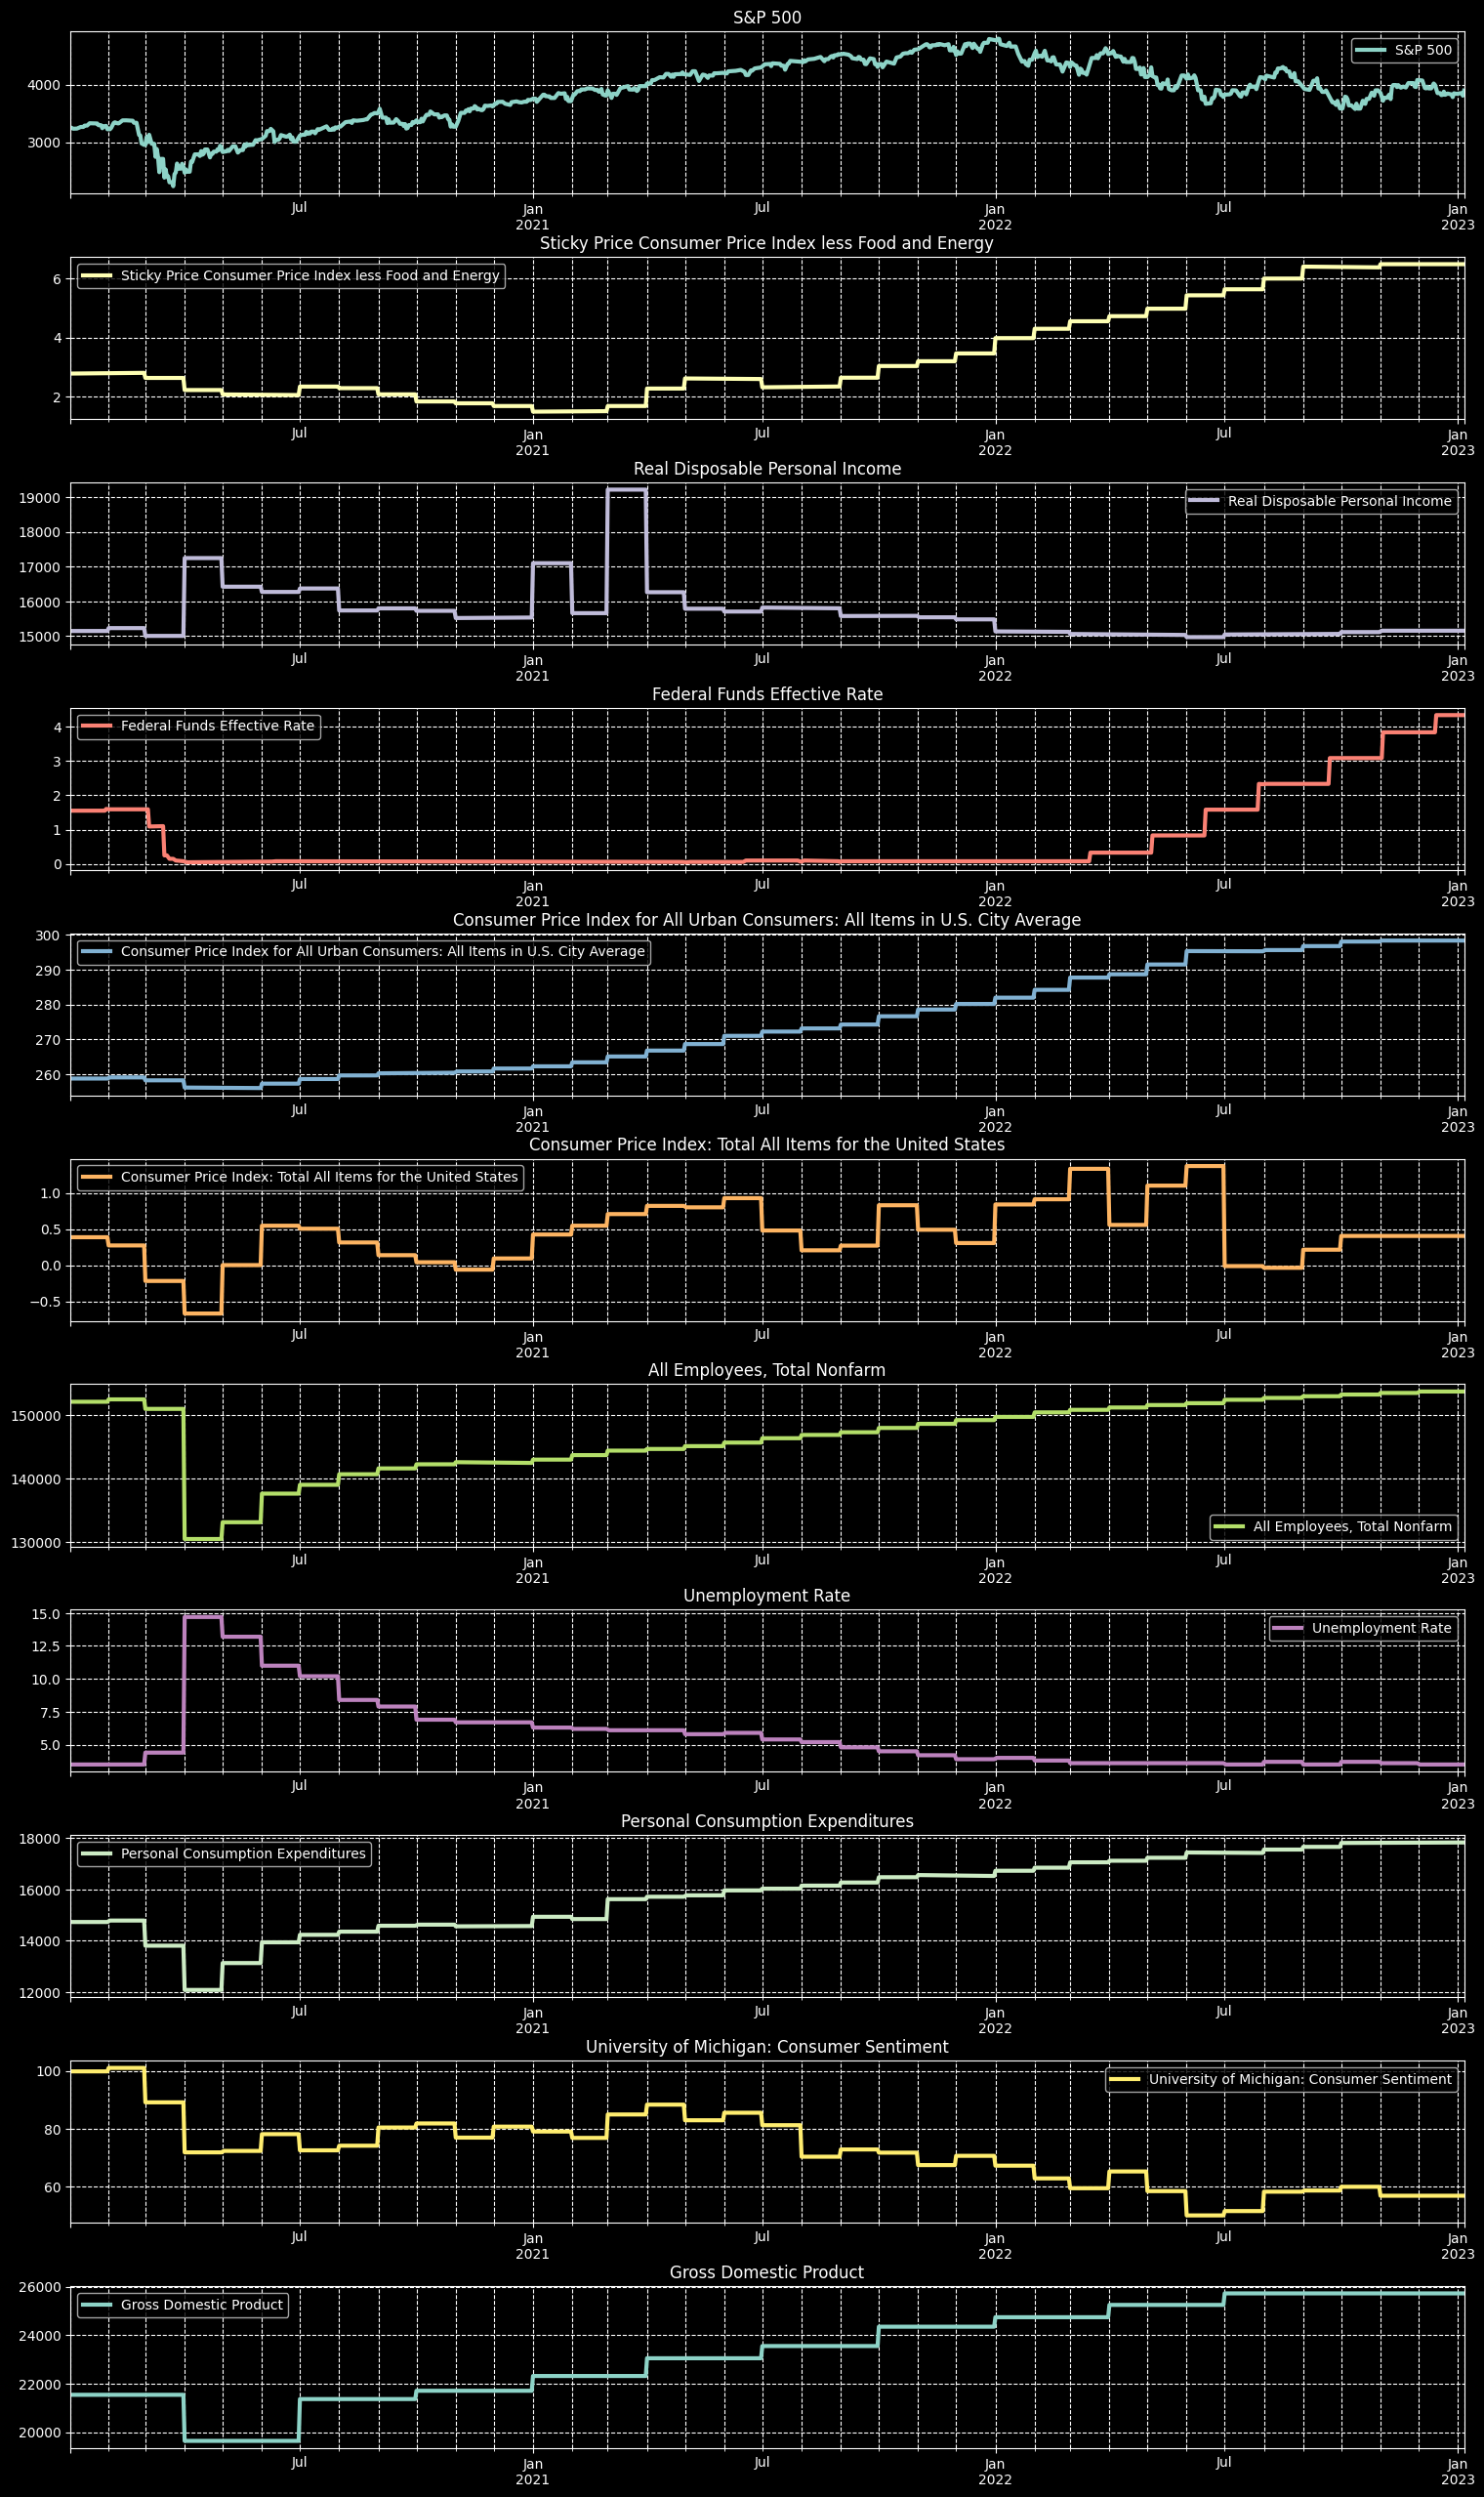

In [36]:
def multiplot_df(df,plot_cols):

  plot_count = len(df.columns.to_list())

  fig, axs = plt.subplots(len(df.columns),sharex=False,figsize=(15,(plot_count*3)))
  title = " Multi Plot"
  #fig.suptitle(title)

  fig.tight_layout(h_pad=4)

  plt.subplots_adjust(top=0.85,bottom=0.1)
  
  plot_features = df[plot_cols]
  _ = plot_features.plot(ax=axs,subplots=True,linewidth=3)

  i = 0
  for ax in axs:
    ax.set_title(str(df.columns[i]))
    ax.grid(True,which='both', axis='both')
    i+=1

update_econ_data(fred_sid_list=FEDIDLIST,fred_start_date='2020-01-01')
data = merge_multiple_dfs(econ_data)
#display(data)
plot_cols = data.columns.to_list()
multiplot_df(data,plot_cols)
# mydf=pd.DataFrame(data['S&P 500'])
# basic_dataframes_chart(mydf,"S&P 500")

In [37]:
def preprocess_data():
    update_econ_data()
    data = merge_multiple_dfs(econ_data)

    Features = data.columns.to_list()
    
    # TODO:
    #   Develop alogo for LSTM Model for predicting SP500
    #   ...
    
preprocess_data()

### Get Formated Datetime from Timestamp

In [38]:
def get_datetime_str_from_timestamp(tstimestamp,datatime_szformat='%Y-%m-%d'):
    """ 
    Convers a python Timestamp valiable into a string formatted per the provided
    szformat string
    format can be found at https://docs.python.org/3/library/datetime.html#strftime-and-strptime-format-codes
    """
    
    return datetime.strftime(tstimestamp, datatime_szformat)

### Get Yahoo Finance Stock Price History

In [39]:
def get_yf_price_history(symbol, period=None,interval='1d',start_date=None,end_date=None):
    """ 
    Calls Yahoo Finance Ticker() function to retrieve stock historical prices 
    and returns a DataFrame
    """
    return yf.Ticker(symbol).history(interval=interval,period=period, start=start_date, end=end_date)

### Get Period Performace DataFrame 

In [40]:
def get_performance_df(df_list,period_start,period_end):
    """ 
    Takes a list of DataFrames of pre-calculated % Change price data
    and creates a Performance DataFrame over the period provided 
    """
    # Create a new dataframe
    perf_df = pd.DataFrame(columns=['Stocks','% Price Change']) 
    i = 0

    # Copy the last row of each stock dataframe into perf_df 
    for s in df_list.keys():
        perf_df.loc[i] = [s,np.round(df_list[s].iloc[-1],2)]
        i+=1

    # Set perf_df to the stocks column
    perf_df.set_index('Stocks',drop=True,inplace=True)
    
    return perf_df

### Retrieve and Compare Changes in Stock Prices

In [51]:
def plot_price_change_comp(stock_list,start_date,end_date,interval):
    """
    Plot multiple stocks price %changes on one chart and returns
    a list of Dataframes for each stock symbob in stock_list 
    """
    
    main_df = {}
    for s in stock_list:
        main_df[s] = get_yf_price_history(symbol=s,interval=interval,start_date=start_date,end_date=end_date)['Close'].pct_change(periods=1).dropna().cumsum() * 100

    ax = ''
    for k in main_df.keys():
        if ax == '':
            ax = main_df[k].plot(figsize=(16,8),linewidth=3)    
        else:
            main_df[k].plot(ax=ax,linewidth=3)

    ax.set_title('Relative Perfomance: % Change of Stock Prices')
    ax.title.set_size(20)

    ax.set_xlabel("Time")
    ax.set_ylabel("% Price Change")

    ax.grid(True)
    ax.legend(main_df.keys())

    plt.show()
    return main_df


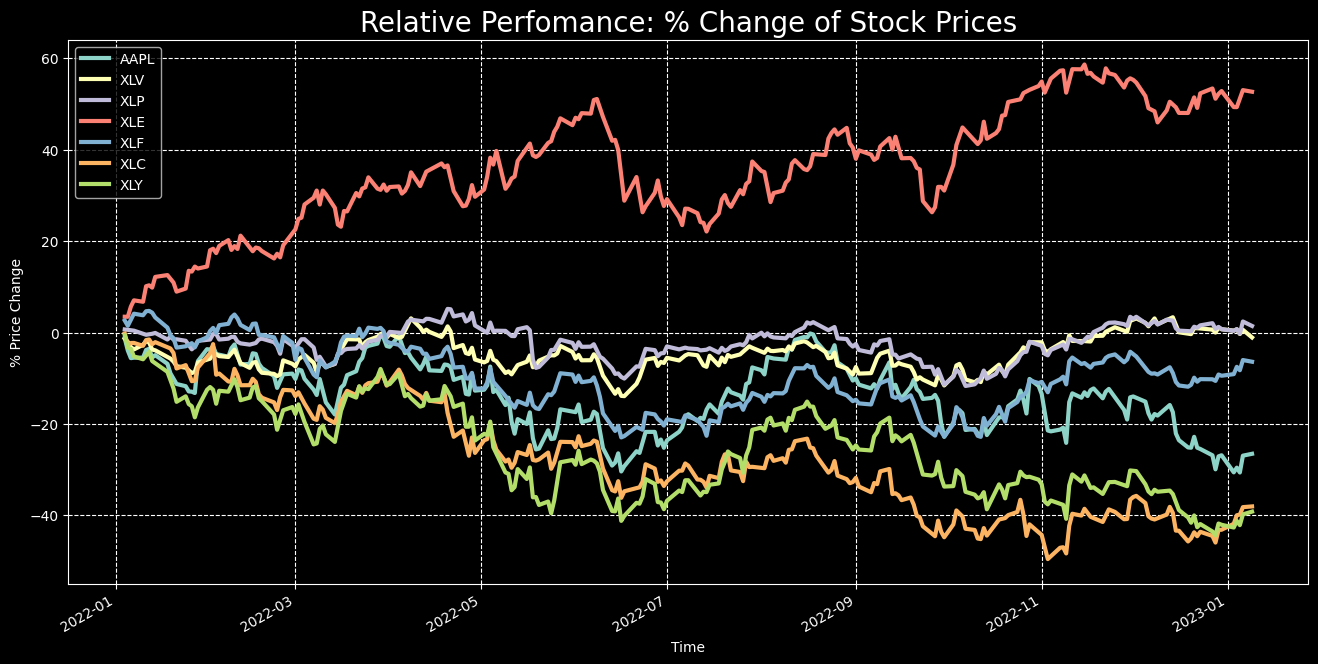

,% Price Change
Stocks,
AAPL,-26.52
XLV,-1.07
XLP,1.44
XLE,52.67
XLF,-6.38
XLC,-38.03
XLY,-39.16


In [62]:

# stock_list = ['^GSPC','AAPL','TSLA','META','AMZN']
stock_list = ['AAPL','XLV','XLP','XLE','XLF','XLC','XLY']
# stock_list = ['AAPL']

start_date = '2022-01-03'
end_date = datetime.today()
interval = '1d'

main_df = plot_price_change_comp(stock_list,start_date,end_date,interval)
perf_df = get_performance_df(df_list=main_df,period_start=start_date,period_end=end_date)
# print('Stock Performaces from',start_date,'to',end_date)
display(HTML('<h3>Stock Performance from '+str(start_date)+' to  '+str(end_date)+'</h3'))
display(perf_df)

In [64]:
def check_sma(price_history: object, SMA_lookback_in_dayes: int) -> float:
    
    # Calculate the stock's SMA
    sma = price_history.rolling(window=SMA_lookback_in_dayes).mean().dropna()
    
    # Calculate the change in the SMA over the 2 periods
    last_sma = np.NaN
    if len(sma) >= 2:
        last_sma = sma.iloc[-1]
        sma_change = last_sma - sma.iloc[-2]
    else:
        sma_change = np.NaN

    return last_sma, sma_change

symb = "AAPL"
start_date = '2017-01-01'
end_date = datetime.now()
interval = "1d"

testdf = yf.Ticker(symb).history(interval=interval, start=start_date, end=end_date)['Close']

sma_periods= [10,20,40,50,200]
date_format = "%A %m-%d-%Y %I:%M%p"
print(len(testdf))
#last_date_str = datetime.strftime(testdf.index[-1], date_format)
last_date_str = get_datetime_str_from_timestamp(testdf.index[-1],date_format)

print('Simple Moving Averages'+str(sma_periods)+' from',start_date,'to',end_date,'('+str(len(testdf))+' Trading Days)')
print(symb,"Price EOD on",last_date_str," = $",np.round(testdf.iloc[-1],2))
for i in sma_periods:
    sma, sma_change = check_sma(testdf, i)
    if( not (sma_change is np.NaN)):
        print("-- SMA("+str(i)+") =",str(np.round(sma,2))+'.',"The % Change in last",i,"days is",np.round(sma_change,2))

print("--")

1515
Simple Moving Averages[10, 20, 40, 50, 200] from 2017-01-01 to 2023-01-09 16:45:17.545069 (1515 Trading Days)
AAPL Price EOD on Monday 01-09-2023 12:00AM  = $ 130.15
-- SMA(10) = 128.37. The % Change in last 10 days is -0.21
-- SMA(20) = 133.12. The % Change in last 20 days is -0.62
-- SMA(40) = 140.2. The % Change in last 40 days is -0.12
-- SMA(50) = 140.93. The % Change in last 50 days is -0.38
-- SMA(200) = 150.31. The % Change in last 200 days is -0.2
--


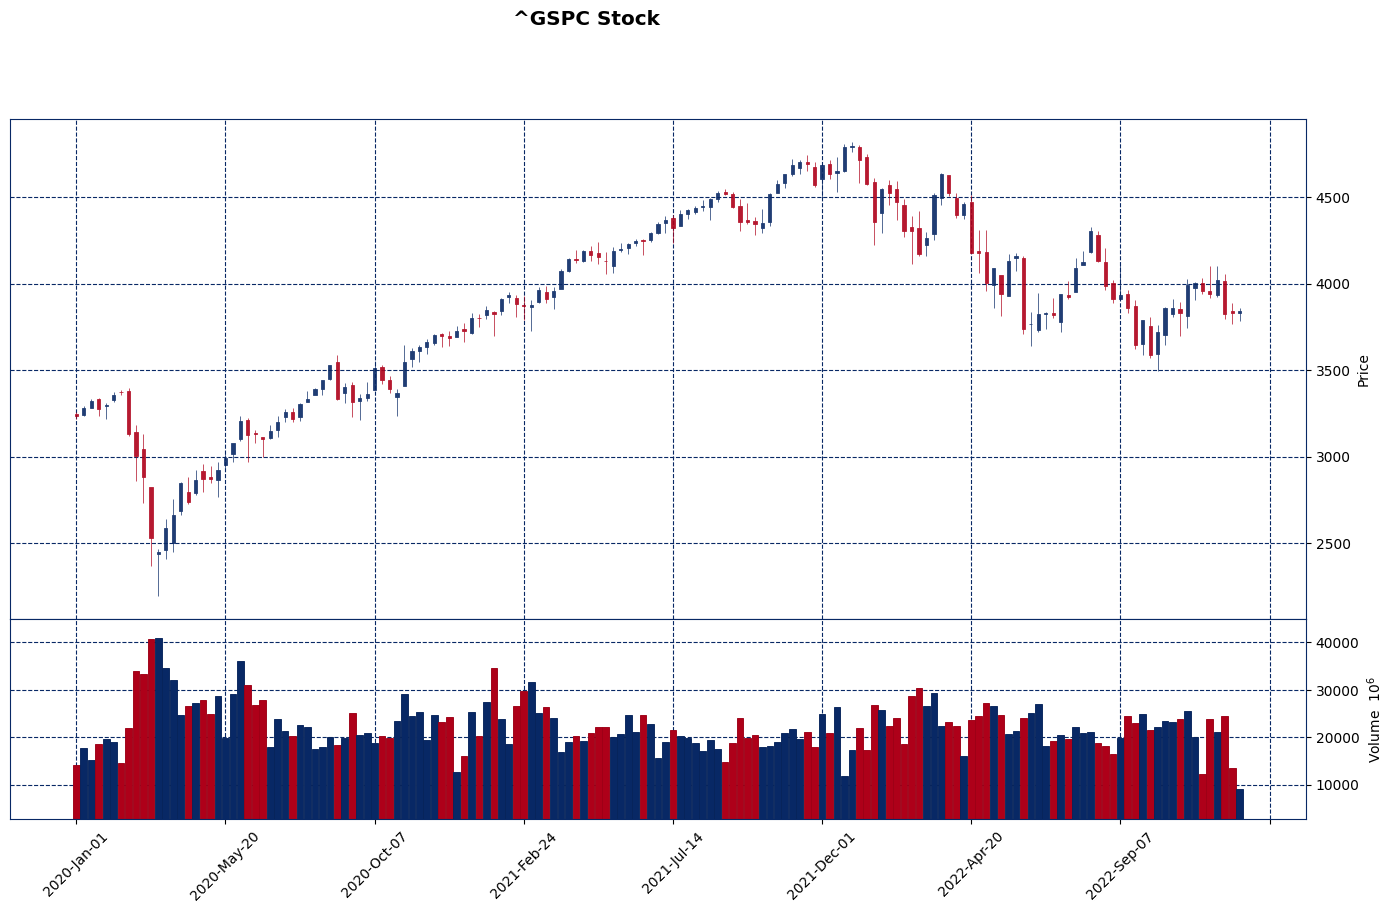

In [65]:
import matplotlib.dates as mpl_dates
import mplfinance as mpf

symbol='^GSPC'
interval = '1wk'

start_date = '2020-01-01'
end_date ='2022-12-31'

# Extracting Data for plotting
data = yf.Ticker(symbol).history(interval=interval,start=start_date, end=end_date)
data.index.name = 'Date'
kwargs={'warn_too_much_data':10000}
mpf.plot(data,figsize=(18,10),type='candle',volume=True,**kwargs,style='sas',title=symbol+" Stock")
